# *Gender Bias in Virtual Assistants Project*

### Identificando Preconceitos de Gênero em Assistentes Virtuais

![From Google](https://media-assets-01.thedrum.com/cache/images/thedrum-prod/s3-news-tmp-145694-untitled_design_70--default--1280.png)

### Equipe formada por
- Bárbara Stéphanie Neves Oliveira, 507526
- Lucas Benjamim Cunha Bandeira, 507533
- Samir Braga Chaves, 513788
- Vinicius Bernardo Gabriel, 475210

# BERT *Classifier for Gender Datasets* 

<center>
  <img width="600" src="https://drive.google.com/uc?id=11KlguWCUIDUzA8bN5dtzzab4tiY_2pz4"/>
</center>


---

### Classificação Multiclasse

<center>
  <img width="400" src="https://lena-voita.github.io/resources/lectures/text_clf/intro/example_document-min.png"/>
</center>

---

### *Transfer-Learning*

<center>
  <img width="700" src="https://lena-voita.github.io/resources/lectures/transfer/intro/idea-min.png"/>
</center>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Packages

In [ ]:
!pip install scikit-multilearn
!pip install transformers
!pip install tensorflow-addons
!pip install keras-tqdm
!pip install livelossplot

# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import *

import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow_addons.metrics import F1Score
from keras.preprocessing.sequence import pad_sequences
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import classification_report

from transformers import BertTokenizer, TFBertForSequenceClassification

BASE_PATH = '/content/drive/MyDrive/Ciência de Dados/Projeto Final'
DATASETS_PATH = BASE_PATH + "/Resources/Datasets"

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [ ]:
# Adicionando módulos customizados ao path
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append(BASE_PATH + '/Modules')

import utils, text, model
from importlib import reload

# Leitura dos Dados

In [ ]:
md_gender = pd.read_csv(DATASETS_PATH + '/MDGender/md_gender_bias/new_data/new_data.csv')
convai2 = pd.read_csv(DATASETS_PATH + '/MDGender/md_gender_bias/convai2_inferred/new_data.csv')
light = pd.read_csv(DATASETS_PATH + '/MDGender/md_gender_bias/light_inferred/new_data.csv')

In [ ]:
md_gender['label_pos_2'] = 0

In [ ]:
full_data = pd.concat([md_gender, light, convai2]).sample(50000, random_state=42)

In [ ]:
labels = ['female', 'male', 'neutral']

# Treinamento do BERT *Classifier*

<center>
  <img width="700" src="https://lena-voita.github.io/resources/lectures/transfer/bert/intro-min.png"/>
</center>

## Representação Textual

<center>
  <img width="700" src="https://lena-voita.github.io/resources/lectures/transfer/bert/bert_input.gif"/>
</center>

In [ ]:
data_sequences = text.padding_sequences(full_data['text_tokens'].to_numpy(), max_length=text.MAX_LENGTH)


Text to sequences for BERT Classifier:   0%|          | 0/50000 [00:00<?, ?it/s]

Padding the sequences...


## Divisão Estratificada

In [ ]:
dict_data_sequences = [
  { k: v for k, v in enumerate(ids) }
  for ids in data_sequences
]

y = full_data[['label_pos_0', 'label_pos_1', 'label_pos_2']].to_numpy()
padded_tokens_ids = data_sequences[0]
stratified_tokens_ids_splits = text.data_split(padded_tokens_ids, y, test_size=0.2, dev_size=0.1, random_seed=42)

In [ ]:
X_train_ids, y_train, X_test_ids, y_test, X_dev_ids, y_dev = stratified_tokens_ids_splits
dict_padded_tokens_ids, dict_padded_masked_ids = dict_data_sequences
X_train_masks = np.array([dict_padded_masked_ids[i] for i in utils.get_keys_by_values(dict_padded_tokens_ids, X_train_ids)])
X_test_masks = np.array([dict_padded_masked_ids[i] for i in utils.get_keys_by_values(dict_padded_tokens_ids, X_test_ids)])
X_dev_masks = np.array([dict_padded_masked_ids[i] for i in utils.get_keys_by_values(dict_padded_tokens_ids, X_dev_ids)])

In [ ]:
from collections import Counter
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

result_comb_matrix = pd.DataFrame({
    'data': Counter(str(combination) for row in get_combination_wise_output_matrix(y, order=1) for combination in row),
    'train': Counter(str(combination) for row in get_combination_wise_output_matrix(y_train, order=1) for combination in row),
    'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(y_test, order=1) for combination in row),
    'dev' : Counter(str(combination) for row in get_combination_wise_output_matrix(y_dev, order=1) for combination in row)
}).T.fillna(0.0)
result_comb_matrix.style.background_gradient(cmap=plt.get_cmap('Pastel2'))

,"(0,)","(2,)","(1,)"
data,12348,26360,11292
train,8890,18979,8131
test,2470,5272,2258
dev,988,2109,903


## Treino dos Modelos

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# f1_score = F1Score(num_classes=len(labels), threshold=0.5, average='weighted')

model_path = BASE_PATH + '/Resources/Models/best_bert_linear_classifier2_general.h5'

auc_score = AUC(multi_label=True)

### MD*Gender*

In [ ]:
model_meta = model.run_text_classifier(
    model.bert_linear_classifier2,
    [X_train_ids, X_train_masks], y_train,
    [X_dev_ids, X_dev_masks], y_dev,
    batch_size=32,
    max_epochs=50,
    patience=10,
    eval_metric=auc_score,
    monitor='val_auc',
    source_length=text.MAX_LENGTH,
    hidden_units=256,
    labels_size=y_train.shape[1], 
    model_path=model_path)

print('\n' + model_meta['run_time'], model_meta['start'], model_meta['final'])

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_for_sequence_classifica TFSequenceClassifier 109483778   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          768         tf_bert_for_sequence_classifi

   6/1125 [..............................] - ETA: 1:10 - loss: 0.6667 - auc: 0.5270WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0084s vs `on_train_batch_end` time: 7.3893s). Check your callbacks.


1125/1125 [==============================] - ETA: 0s - loss: 0.5115 - auc: 0.7393WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


1125/1125 [==============================] - 147s 70ms/step - loss: 0.5115 - auc: 0.7393 - val_loss: 0.4295 - val_auc: 0.8422

Epoch 00001: val_auc improved from -inf to 0.84223, saving model to /content/drive/MyDrive/Ciência de Dados/Projeto Final/Resources/Models/best_bert_linear_classifier2_general.h5
Epoch 2/50
1125/1125 [==============================] - 72s 64ms/step - loss: 0.3797 - auc: 0.8778 - val_loss: 0.4150 - val_auc: 0.8561

Epoch 00002: val_auc improved from 0.84223 to 0.85606, saving model to /content/drive/MyDrive/Ciência de Dados/Projeto Final/Resources/Models/best_bert_linear_classifier2_general.h5
Epoch 3/50
1125/1125 [==============================] - 73s 65ms/step - loss: 0.3043 - auc: 0.9238 - val_loss: 0.4445 - val_auc: 0.8494

Epoch 00003: val_auc did not improve from 0.85606
Epoch 4/50
1125/1125 [==============================] - 71s 63ms/step - loss: 0.2393 - auc: 0.9526 - val_loss: 0.4586 - val_auc: 0.8554

Epoch 00004: val_auc did not improve from 0.85606

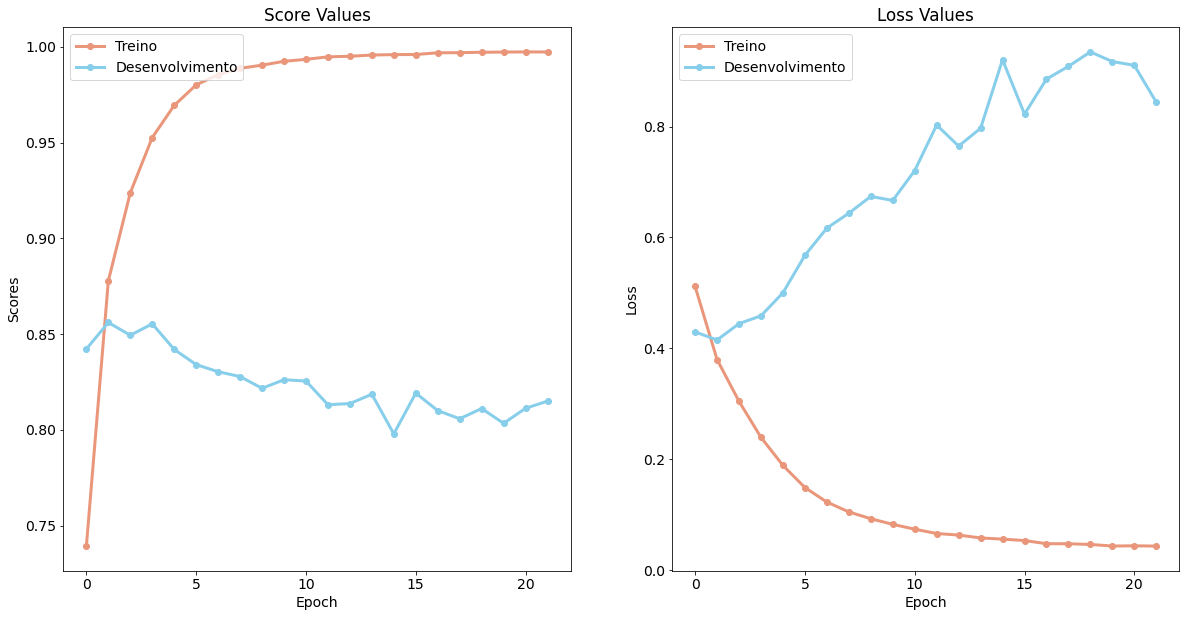

In [ ]:
model.plot_model_loss_score(model_meta['history'], score_name='auc')

### Extra

In [ ]:
model = model_meta['model']
model.load_weights(model_path)
y_pred = np.rint(model.predict([X_test_ids, X_test_masks]))
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

      female       0.72      0.52      0.60      2470
        male       0.74      0.55      0.64      2258
     neutral       0.76      0.84      0.80      5272

   micro avg       0.75      0.70      0.72     10000
   macro avg       0.74      0.64      0.68     10000
weighted avg       0.75      0.70      0.71     10000
 samples avg       0.70      0.70      0.70     10000

